# Overcomplete Tomography

This notebook demonstrates a simple, noiseless, synthetic 2D example of overcomplete tomography as implemented in this package.

In [1]:
from octo.overcomplete import OvercompleteBasis
from octo.basis import PixelBasis2D, CosineBasis2D
from octo.measurement import PathIntegral

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
rng = np.random.default_rng(42)

We will use to families of 2D basis functions: Cosine and Pixel.
To keep things simple, we will deal with square images and bases with the same number of basis functions

In [10]:
Nx = 20  # number of basis functions in x
Ny = 20  # number of basis functions in y
cosine = CosineBasis2D(Nx, Ny)
pixel = PixelBasis2D(Nx, Ny)
nparams = cosine.N + pixel.N
print(f"Total number of parameters: {nparams}")

Total number of parameters: 800


## Synthetic Data

Start by creating a ground truth image, combining global and local features

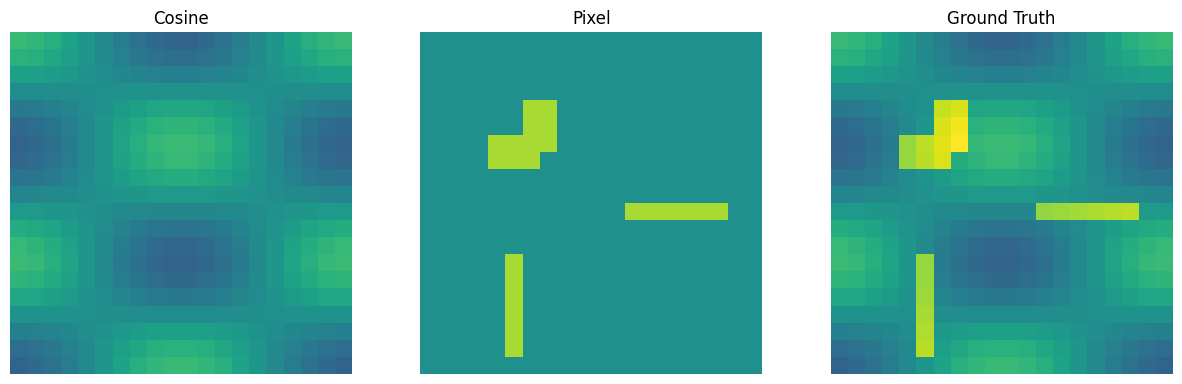

In [11]:
true_cosine_coefficients = np.zeros((Nx * Ny))
true_cosine_coefficients[3 * Ny + 2] = 1
true_cosine_image = cosine(true_cosine_coefficients)

true_pixel_coefficients = np.zeros((Nx, Ny))
true_pixel_coefficients[4:7, 6:8] = 0.2
true_pixel_coefficients[6:8, 4:7] = 0.2
true_pixel_coefficients[10, 12:18] = 0.2
true_pixel_coefficients[13:19, 5] = 0.2
true_pixel_coefficients = true_pixel_coefficients.flatten()
true_pixle_image = pixel(true_pixel_coefficients)

true_image = true_pixle_image + true_cosine_image
vmax = np.max(true_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_cosine_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("Cosine")

axs[1].imshow(true_pixle_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Pixel")

axs[2].imshow(true_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Ground Truth")

[ax.axis("off") for ax in axs]
plt.show()

Create a synthetic noiseless dataset.  The forward model here is simple path integration for paths that travel all the way across the image

$$d_i = \int_{\Gamma_i} f(x,y) \mathrm{d}s_i$$

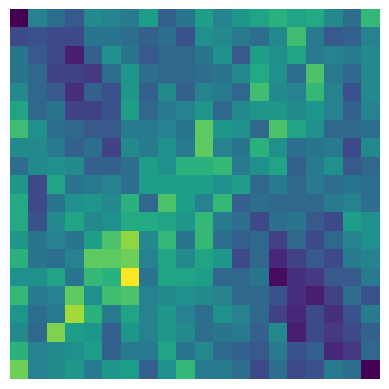

In [12]:
npaths=500
measurement = PathIntegral(Nx, Ny, npaths=npaths)

pm = np.sum(measurement.path_matrix.reshape((npaths, Nx, Ny)), axis=0)
plt.imshow(pm)
plt.gca().axis("off")
plt.show()

In [13]:
synthetic = measurement(true_image)

## Overcomplete Basis

Let's have a look at the two families of basis functions we have.
In the following plots the black dashed lines separate each 2D basis function.
Note that this is not how the basis functions are aranged in the `basis` instance, rather they are aranged as column vectors.

The cosine basis functions have global support, and have been normalised so as to form an orthonormal basis.
They are defined in the range $(0, \pi]$, and in the discrete case the number of basis functions in a given direction, say $N_x$, determines the maximum frequency in that direction as per the Nyquist sampling theorem.
For plotting purposes, the basis functions have been upsampled by a factor of 10 in both directions.

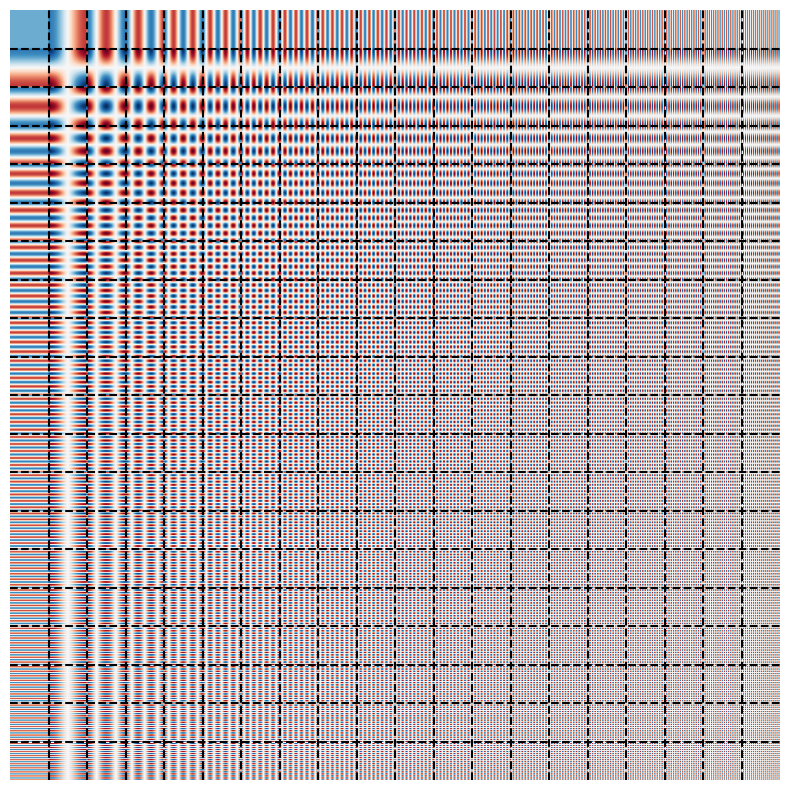

In [9]:
cosine.plot(figsize=(10, 10))

The pixel basis functions have localised support.
They are very simply indicator functions for each pixel in the image.

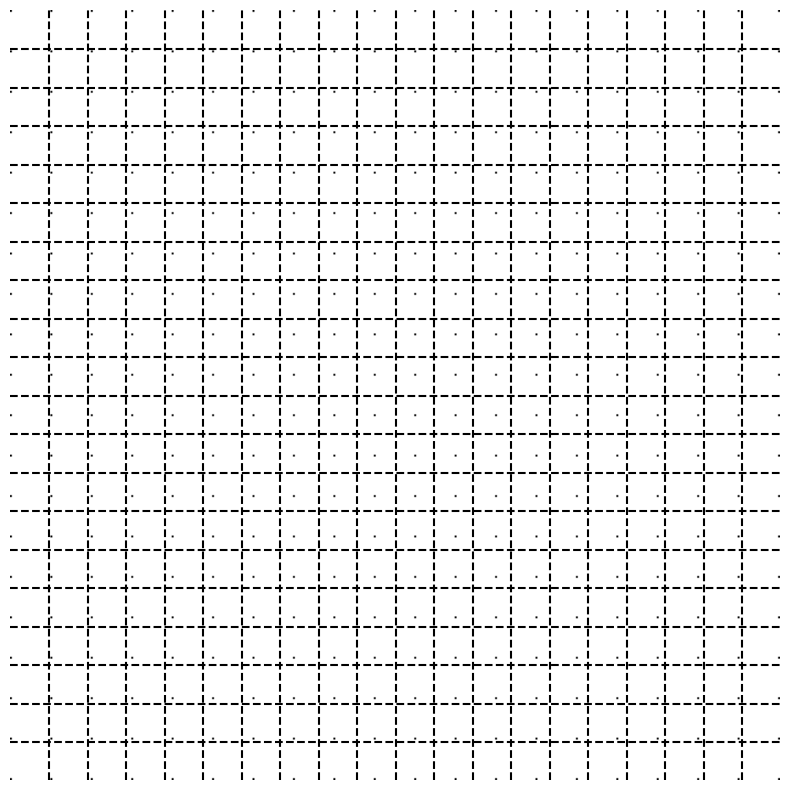

In [8]:
pixel.plot(figsize=(10, 10))

To set up the inverse problem, we first compute the Jacobian matrices of each basis.
The Jacboian is the action of the predictive forward measurement model on each of the individual basis functions.

In [14]:
cosine.compute_jacobian(measurement)
pixel.compute_jacobian(measurement)

Now we come to the crux of overcomplete tomography.
Using the `OvercompleteBasis` class, we create an instance that combines our two familes of basis functions with some weights.
Under the hood, this computes an overall Jacobian, and sets up the objective function to be optimised given the observed data and some regularisation.
By default, the regularisation is an $\ell_1$-norm, with some further weighting to account for the different "units" of the basis function.

In [15]:
overcomplete = OvercompleteBasis(synthetic, [cosine, pixel], bweights=[1, 1], rweight=1e-3)

## Solve the inverse problem

Here we simply minimise the cost function with `scipy.optimize.minimize`.
Other options are available.

In [16]:
# should implement a cost function gradient for faster convergence
result = minimize(
    overcomplete.cost,
    rng.uniform(-1, 1, nparams),
    method="L-BFGS-B",
    jac=overcomplete.cost_gradient,
)

Here we plot the resulting image in the individual bases and combined.

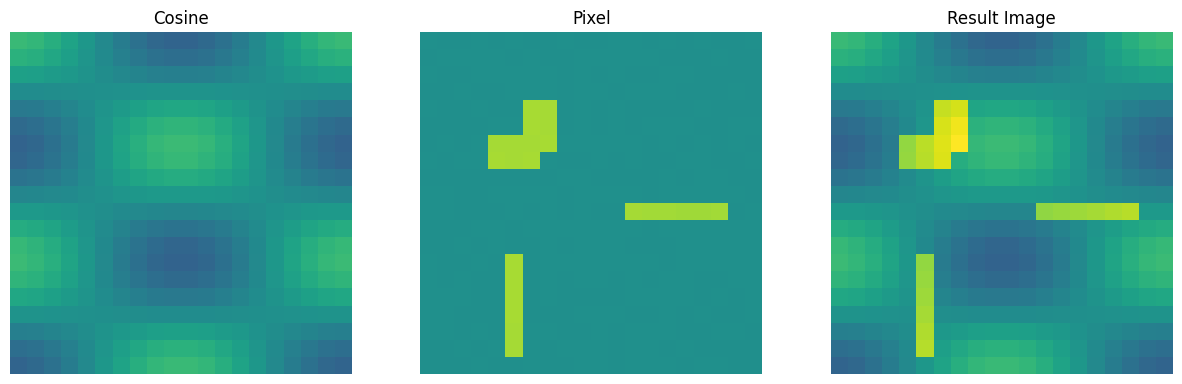

In [18]:
result_coefficients = overcomplete._split(result.x)

result_cosine_image = cosine(result_coefficients[0])
result_pixel_image = pixel(result_coefficients[1])
result_image = result_cosine_image + result_pixel_image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(result_cosine_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("Cosine")

axs[1].imshow(result_pixel_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Pixel")

axs[2].imshow(result_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Result Image")

[ax.axis("off") for ax in axs]
plt.show()

And now we compare with the true image.

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

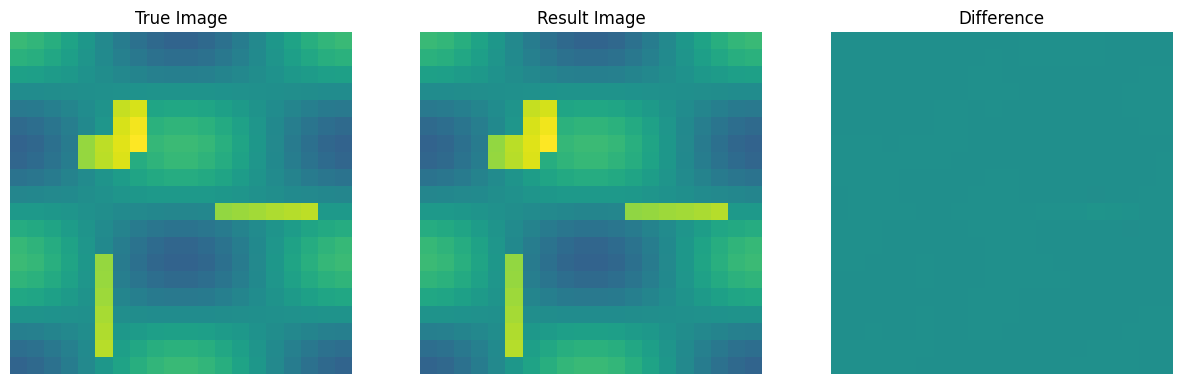

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[0].set_title("True Image")

axs[1].imshow(result_image.reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[1].set_title("Result Image")

axs[2].imshow((true_image - result_image).reshape(Nx, Ny), vmin=-vmax, vmax=vmax)
axs[2].set_title("Difference")

[ax.axis("off") for ax in axs]

We have excellent recovery of both the smooth background and discontinuous foreground features!

Here we visialise the distributions of the recovered parameters.
Thanks to the $\ell_1$ regularisation, we have a sparse solution.

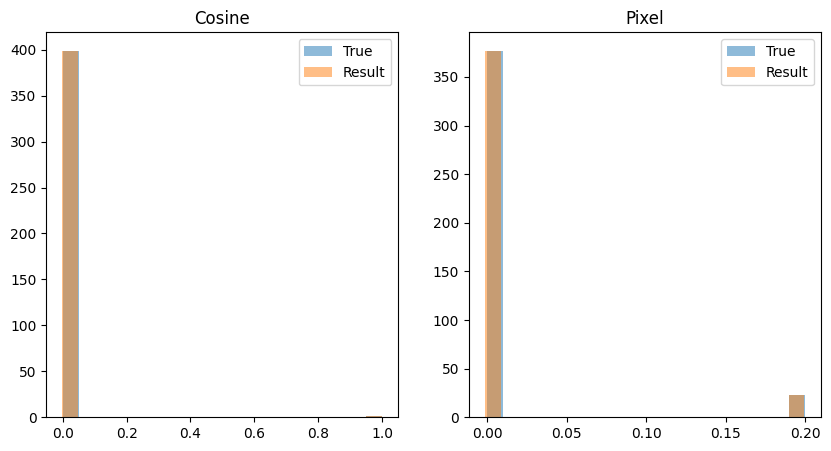

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(true_cosine_coefficients, bins=20, alpha=0.5, label="True")
axs[0].hist(result_coefficients[0], bins=20, alpha=0.5, label="Result")
axs[0].set_title("Cosine")

axs[1].hist(true_pixel_coefficients, bins=20, alpha=0.5, label="True")
axs[1].hist(result_coefficients[1], bins=20, alpha=0.5, label="Result")
axs[1].set_title("Pixel")

[ax.legend() for ax in axs]
plt.show()

And directly comparing individual parameters with their true values, we see they are very close!

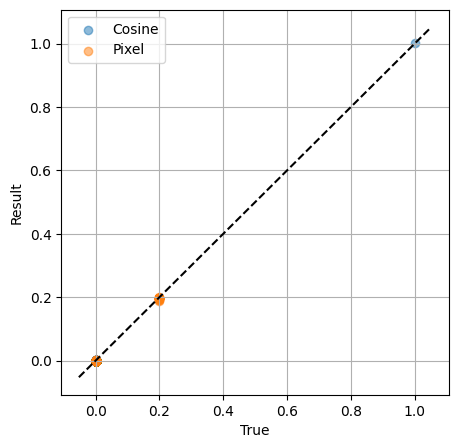

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.scatter(true_cosine_coefficients, result_coefficients[0], alpha=0.5, label="Cosine")
axs.scatter(true_pixel_coefficients, result_coefficients[1], alpha=0.5, label="Pixel")
axs.set_xlabel("True")
axs.set_ylabel("Result")

_min = np.min([axs.get_xlim()[0], axs.get_ylim()[0]])
_max = np.max([axs.get_xlim()[1], axs.get_ylim()[1]])
axs.plot([_min, _max], [_min, _max], color="black", ls="--")
axs.grid()
axs.legend()